# Investigating NEAR's SSN radar residuals

## Simulating the DSN-inferred trajectory
1. For orbital elements, use JPL Horizons values for NEAR's position and velocity __some time before__ the end of two-way Doppler tracking by DSS Goldstone.
2. Construct time line (epochs) within this tracked period.
3. Fetch the Horizons position and velocity at the start and compute orbital elements.
4. Compute the trajectory over this tracked period to use as reference.
5. Estimate the _lags in the two-way Doppler data_ over this tracked period using the reference trajectory.
6. Apply least square fit to the lagging Doppler data to compute new orbital elements.
7. Compute and plot range residuals subtended at the radar stations between the reference and fitted trajectories.


In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np

from stations import dss25, ssrAltair, ssrMillstone
from tracking import Tracking
from util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
sim_meas = []
sim_altair_rv = []
sim_millstone_rv = []
sim_dss25_rv = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    rv = near_ssn_ref_ephem.rv(e)

    sim_rv = ssrAltair.rv_with_rangelag(rv, e)
    sim_altair_rv.append(sim_rv)
    sim_altair_r, sim_altair_rr = ssrAltair.range_and_rate(sim_rv, e)

    sim_rv = ssrMillstone.rv_with_rangelag(rv, e)
    sim_millstone_rv.append(sim_rv)
    sim_millstone_r, sim_millstone_rr = ssrMillstone.range_and_rate(sim_rv, e)


    sim_rv = dss25.rv_with_rangelag(rv, e)
    sim_dss25_rv.append(sim_rv)
    sim_dss25_r, sim_dss25_rr = dss25.range_and_rate(sim_rv, e)

    sim_meas.append([sim_altair_r, sim_millstone_r, sim_dss25_r])

print(sim_meas)

[[<Quantity 35482.10823583 km>, <Quantity 35325.44019592 km>, <Quantity 32924.26352929 km>], [<Quantity 34992.67025567 km>, <Quantity 34871.30243306 km>, <Quantity 32463.47561342 km>], [<Quantity 34503.06081226 km>, <Quantity 34416.81559206 km>, <Quantity 32002.56940969 km>], [<Quantity 34013.28827363 km>, <Quantity 33961.97897874 km>, <Quantity 31541.55410871 km>], [<Quantity 33523.36197989 km>, <Quantity 33506.79230523 km>, <Quantity 31080.43998528 km>], [<Quantity 33033.29233821 km>, <Quantity 33051.25573733 km>, <Quantity 30619.23850417 km>], [<Quantity 32543.09092759 km>, <Quantity 32595.3699471 km>, <Quantity 30157.96243708 km>], [<Quantity 32052.77061475 km>, <Quantity 32139.13617115 km>, <Quantity 29696.6259919 km>], [<Quantity 31562.34568238 km>, <Quantity 31682.55627556 km>, <Quantity 29235.24495599 km>], [<Quantity 31071.83197126 km>, <Quantity 31225.63282792 km>, <Quantity 28773.83685488 km>], [<Quantity 30581.2470378 km>, <Quantity 30768.36917765 km>, <Quantity 28312.42112

In [6]:
from fitorbit import OrbitFitter
fitter = OrbitFitter(near_ssn_horizons_orbit, [ssrAltair, ssrMillstone, dss25], var=0.001, debug=True)

Range constraints:
a: -8485822.711542351 -8502811.345599491
ecc: 1.811545437071758 1.8151721546634931
inc: 1.8825937595496878 1.8863627160252625


In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_range_data(ssn_offsets, sim_meas)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8133587958946467, 'inc': 1.8844782377874751, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.8133587958676256, 'inc': 1.884478237815556, 'nu': -1.850038352972503, 'raan': 1.540058992690365, 'argp': 2.5332574240177483}
{'a': -8494317.028570922, 'ecc': 1.

In [8]:
print(fitter.result.residual)

[ 92.47646051  85.37359291  35.3445697   84.370273    78.91956052
  29.43343595  76.40691059  72.56632794  23.68577584  68.59385091
  66.31876974  18.1098286   60.93906444  60.18207199  12.71438046
  53.45105415  54.16175653   7.50880852  46.13889835  48.2637069
   2.50312834  39.01229782  42.49419696  -2.29195385  32.08162747
  36.85992221  -6.864984    25.35799292  31.36803401 -11.20369762
  18.85329215  26.02617667 -15.29495151  12.58028413  20.8425289
 -19.12464818   6.55266272  15.82584803 -22.67765401   0.78513981
  10.98552023 -25.93770782  -4.70646495   6.33161399 -28.88732208
  -9.90512439   1.87494005 -31.50767315 -14.79249365  -2.37288267
 -33.77848061 -19.34878969  -6.39935502 -35.6778752  -23.55265721
 -10.19101735 -37.18225252 -27.38102155 -13.73336149 -38.26611272
 -30.80892559 -17.01073303 -38.90188346 -33.80934974 -20.00622317
 -39.05972523 -36.35301347 -22.70154955 -38.70731738 -38.40815521
 -25.07692326 -37.80962234 -39.94029003 -27.11090211 -36.32862711
 -40.9119417

In [9]:
fitted_ephem = fitter.ephem
describe_trajectory(fitted_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32463.50504685806 km 14333.015541629562 km
Start and end radial speeds: -7.678865828521388 km / s -6.934610646974185 km / s
Closest: 14333.015541629562 km speed 9.426917532774658 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.303212883150177 deg


In [10]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for i, o in enumerate(ssn_offsets):
    e = ssn_start + o*u.s
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(sim_altair_rv[i], e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitted_ephem.rv(e), e)
    altair_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(sim_millstone_rv[i], e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitted_ephem.rv(e), e)
    millstone_shifts.append((meas_r - ref_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(sim_dss25_rv[i], e)
    meas_r, meas_rr = dss25.range_and_rate(fitted_ephem.rv(e), e)
    dss25_shifts.append((meas_r - ref_r).to_value(u.m))

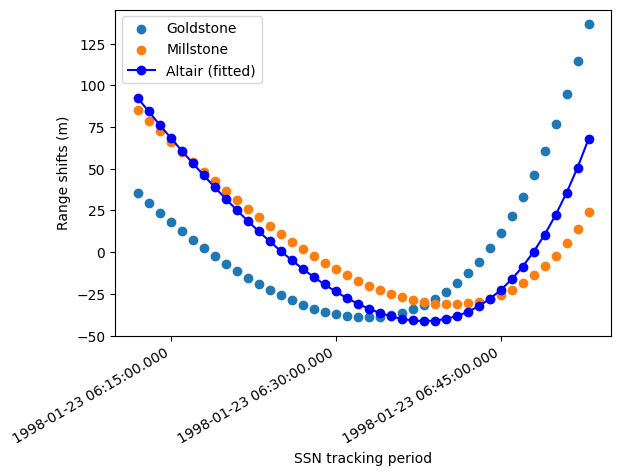

In [11]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Range shifts (m)')
    plt.scatter(ssn_epochs, dss25_shifts, label="Goldstone")
    plt.scatter(ssn_epochs, millstone_shifts, label="Millstone")
    plt.plot(ssn_epochs, altair_shifts, 'bo-', label="Altair (fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [12]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    ref_rv = near_ssn_ref_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrAltair.range_and_rate(fitted_ephem.rv(e), e)
    altair_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    meas_r, meas_rr = ssrMillstone.range_and_rate(fitted_ephem.rv(e), e)
    millstone_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    meas_r, meas_rr = dss25.range_and_rate(fitted_ephem.rv(e), e)
    dss25_doppler.append((meas_rr - ref_rr).to_value(u.m/u.s))

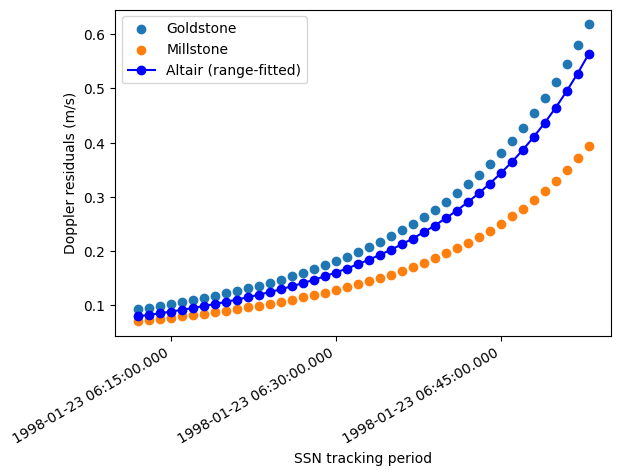

In [13]:
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Doppler residuals (m/s)')
    plt.scatter(ssn_epochs, dss25_doppler, label="Goldstone")
    plt.scatter(ssn_epochs, millstone_doppler, label="Millstone")
    plt.plot(ssn_epochs, altair_doppler, 'bo-', label="Altair (range-fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()